In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import cv2
from PIL import Image
import torch
from torch import nn
import torch.optim as optim
import torchvision.models as models



# Data Preparation

In [2]:
# define all parameter
TrainSampleNo = 300
SampleNo = 100
batch = 16 

In [3]:
def get_data_extract():
        if "food-101" in os.listdir():
            print("Dataset already exists")
        else:
            print("Downloading the data...")
            !wget http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz
            print("Dataset downloaded!")
            print("Extracting data..")
            !tar xzvf food-101.tar.gz
            print("Extraction done!")

In [4]:
get_data_extract()

Dataset already exists


In [5]:
!ls food-101/images/

'ls' is not recognized as an internal or external command,
operable program or batch file.


In [6]:
#read the train.txt and test.txt file and create a dataframe with columns: filepath and label 
path = 'food-101/images'
def create_dataframe(data_file):
  data = []
  with open(data_file, "r") as f:
    for line in f:
      label, id = line.strip().split("/")
      full_path = os.path.join(path,label, id + ".jpg")
      data.append((full_path, label))
  df = pd.DataFrame(data, columns=["Filepath", "Label"])
  return df
train_df = create_dataframe("food-101/meta/train.txt")
test_df = create_dataframe("food-101/meta/test.txt")

In [8]:
#Sample the dataset
train_df, valid_df = train_test_split(train_df, train_size=0.8, stratify=train_df['Label'], shuffle=True, random_state=1)

grouped_df = train_df.groupby('Label')
train_df = grouped_df.apply(lambda x: x.sample(TrainSampleNo)).reset_index(drop=True)

grouped_df = valid_df.groupby('Label')
valid_df = grouped_df.apply(lambda x: x.sample(SampleNo)).reset_index(drop=True)

grouped_df = train_df.groupby('Label')
test_df = grouped_df.apply(lambda x: x.sample(SampleNo)).reset_index(drop=True)

class_names = train_df['Label'].unique().tolist()
class_to_idx = {class_name: idx for idx, class_name in enumerate(class_names)}

In [9]:
#print the sample number

train_counts = train_df['Label'].value_counts()

valid_counts = valid_df['Label'].value_counts()

test_counts = test_df['Label'].value_counts()


print(train_counts + valid_counts + test_counts)


apple_pie        500
miso_soup        500
peking_duck      500
panna_cotta      500
pancakes         500
                ... 
donuts           500
deviled_eggs     500
cup_cakes        500
croque_madame    500
waffles          500
Name: Label, Length: 101, dtype: int64


# Data loader

In [23]:
from torch.utils.data import Dataset
from torchvision import transforms
import cv2
from PIL import Image

class MyFood101Dataset(Dataset):
    def __init__(self, data_df, transform=None):
        self.data_df = data_df
        self.transform = transform

    def __len__(self):
        return len(self.data_df)

    def __getitem__(self, idx):
        image_path = self.data_df.loc[idx, 'Filepath']
        label = self.data_df.loc[idx, 'Label']
        label_idx = class_to_idx[label]  # Convert label to index
        image = cv2.imread(image_path)
        image = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))  # Convert ndarray image to PIL Image

        if self.transform:
            image = self.transform(image)

        return image, label_idx

transform = transforms.Compose([
    transforms.Resize((224, 224)), # Crop a random portion of image and resize it to a given size.
    transforms.RandomHorizontalFlip(), # Horizontally flip the given image randomly
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # Normalize the image, Mean and Std of image as also used when training the model
])

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_dataset = MyFood101Dataset(train_df, transform=transform)
valid_dataset = MyFood101Dataset(valid_df, transform=transform_test)
test_dataset = MyFood101Dataset(test_df, transform=transform_test)

In [24]:
from torch.utils.data import DataLoader
train_loader = DataLoader(train_dataset, batch_size= batch, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size= batch)
test_loader  = DataLoader(test_dataset, batch_size= batch)

# Define Custome Head

In [11]:
import os
from pathlib import Path
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split
import torchvision.models as models
import torch.optim as optim
import torch.nn as nn
import torchvision.transforms.functional as TF
from PIL import Image
import matplotlib.pyplot as plt

In [12]:
num_classes = 101
dropout_ratio = 0.5
googlenet = models.googlenet(pretrained=True)
num_features = googlenet.fc.in_features

c:\Users\moknotebook\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\moknotebook\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


# GoogLeNet Model 1

In [13]:
googlenet = models.googlenet(pretrained=True)
for name, param in googlenet.named_parameters():
  # Freeze all layers except inception4e and inception5b (and their sub-modules)
  if 'inception4e' in name or 'inception5b' in name:
    param.requires_grad = True  # Unfreeze inception4e, inception5b and their layers
  else:
    param.requires_grad = False  # Freeze all other layers

In [14]:
# Reshape the tensor before the model head
class CustomModelHead(nn.Module):
  def __init__(self, num_features, dropout_ratio=0.2):
    super(CustomModelHead, self).__init__()
    self.adaptive_pool = nn.AdaptiveAvgPool2d((1, 1))
    self.flatten = nn.Flatten()
    self.fc1 = nn.Linear(num_features, 512)
    self.relu1 = nn.ReLU()
    self.dropout1 = nn.Dropout(p=dropout_ratio)  # Add dropout layer
    self.fc2 = nn.Linear(512, 256)
    self.relu2 = nn.ReLU()
    self.dropout2 = nn.Dropout(p=dropout_ratio)  # Add dropout layer
    self.fc3 = nn.Linear(256, num_classes)
    self.log_softmax = nn.LogSoftmax(dim=1)

  def forward(self, x):
    x = self.adaptive_pool(x.unsqueeze(-1).unsqueeze(-1))
    x = self.flatten(x)
    x = self.fc1(x)
    x = self.relu1(x)
    x = self.dropout1(x)  # Apply dropout after ReLU
    x = self.fc2(x)
    x = self.relu2(x)
    x = self.dropout2(x)  # Apply dropout after ReLU
    x = self.fc3(x)
    x = self.log_softmax(x)
    return x


In [15]:
# Replace the model head with the custom head
googlenet.fc = CustomModelHead(num_features)
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#googlenet.to(device)

In [16]:
# Define a function to check if a parameter requires gradient
def is_unfrozen(parameter):
  return parameter.requires_grad

# Print the names of unfrozen layers
num = 0
for name, parameter in googlenet.named_parameters():
  if is_unfrozen(parameter):
    print(name)
    num+=1
print(num)

inception4e.branch1.conv.weight
inception4e.branch1.bn.weight
inception4e.branch1.bn.bias
inception4e.branch2.0.conv.weight
inception4e.branch2.0.bn.weight
inception4e.branch2.0.bn.bias
inception4e.branch2.1.conv.weight
inception4e.branch2.1.bn.weight
inception4e.branch2.1.bn.bias
inception4e.branch3.0.conv.weight
inception4e.branch3.0.bn.weight
inception4e.branch3.0.bn.bias
inception4e.branch3.1.conv.weight
inception4e.branch3.1.bn.weight
inception4e.branch3.1.bn.bias
inception4e.branch4.1.conv.weight
inception4e.branch4.1.bn.weight
inception4e.branch4.1.bn.bias
inception5b.branch1.conv.weight
inception5b.branch1.bn.weight
inception5b.branch1.bn.bias
inception5b.branch2.0.conv.weight
inception5b.branch2.0.bn.weight
inception5b.branch2.0.bn.bias
inception5b.branch2.1.conv.weight
inception5b.branch2.1.bn.weight
inception5b.branch2.1.bn.bias
inception5b.branch3.0.conv.weight
inception5b.branch3.0.bn.weight
inception5b.branch3.0.bn.bias
inception5b.branch3.1.conv.weight
inception5b.branch

In [17]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(googlenet.parameters(), lr=0.0001)

In [18]:
# parameters

checkpoint_path = 'H:\\My Drive\\UTS SEM4\\94691 Deep Learning\\DL_AT2\\checkpoints_vscode'

from torch.optim.lr_scheduler import ReduceLROnPlateau  # Import ReduceLROnPlateau scheduler from PyTorch

class CustomCallback:
    def __init__(self, early_stop_patience=5, reduce_lr_factor=0.2, reduce_lr_patience=3, reduce_lr_min_lr=0.0000001, checkpoint_path= checkpoint_path, log_dir='logs'):
        # Initialize callback parameters
        self.early_stop_patience = early_stop_patience  # Patience for early stopping
        self.reduce_lr_factor = reduce_lr_factor  # Factor by which to reduce learning rate
        self.reduce_lr_patience = reduce_lr_patience  # Patience for reducing learning rate
        self.reduce_lr_min_lr = reduce_lr_min_lr  # Minimum learning rate
        #self.checkpoint_path = checkpoint_path  # Path to save model checkpoints
        # self.log_dir = log_dir  # Directory for logging

        # Initialize variables for early stopping
        self.early_stop_counter = 0  # Counter for early stopping
        self.best_val_loss = float('inf')  # Best validation loss

        self.optimizer = None  # Optimizer for training
        self.scheduler = None  # Learning rate scheduler

    def set_optimizer(self, optimizer):
        # Set optimizer for training
        self.optimizer = optimizer

    def on_epoch_end(self, epoch, val_loss):
        # Early Stopping
        if val_loss < self.best_val_loss:
            self.best_val_loss = val_loss
            self.early_stop_counter = 0  # Reset counter if validation loss improves
        else:
            self.early_stop_counter += 1  # Increment counter if validation loss does not improve

        if self.early_stop_counter >= self.early_stop_patience:
            print("Early stopping triggered!")
            return True  # Stop training if early stopping criterion is met

        # Reduce LR on Plateau
        if self.scheduler is not None:
            self.scheduler.step(val_loss)  # Adjust learning rate based on validation loss

        return False  # Continue training

    def on_train_begin(self):
        # Initialize Reduce LR on Plateau scheduler
        self.scheduler = ReduceLROnPlateau(self.optimizer, mode='min', factor=self.reduce_lr_factor,
                                            patience=self.reduce_lr_patience, min_lr=self.reduce_lr_min_lr)

    def on_train_end(self):
       pass
    def set_model(self, model):
        self.model = model  # Set model for the callback

In [19]:
custom_callback = CustomCallback()
custom_callback.set_optimizer(optimizer)
custom_callback.set_model(googlenet)

In [20]:
lr_scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, min_lr=1e-6)

In [25]:
# Initialize lists to store epoch-wise values
train_losses = []  # List to store training losses
train_accuracies = []  # List to store training accuracies
val_losses = []  # List to store validation losses
val_accuracies = []  # List to store validation accuracies

num_epochs = 30
# Training loop
for epoch in range(num_epochs):
    # Training
    # Inside the training loop
    running_train_loss = 0.0  # Initialize running training loss
    correct_train = 0  # Initialize number of correctly predicted training samples
    total_train = 0  # Initialize total number of training samples
    for inputs, labels in train_loader:
        # inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = googlenet(inputs)
        if isinstance(outputs, tuple):
            logits = outputs[0]
        else:
            logits = outputs

        # Ensure proper gradient tracking
        #logits.requires_grad = True
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(logits, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
    # Calculate epoch-wise training loss and accuracy
    epoch_train_loss = running_train_loss / len(train_loader.dataset)  # Average training loss
    train_accuracy = correct_train / total_train  # Training accuracy

    # Validation
    googlenet.eval()  # Set the model to evaluation mode
    running_val_loss = 0.0  # Initialize running validation loss
    correct_val = 0  # Initialize number of correctly predicted validation samples
    total_val = 0  # Initialize total number of validation samples
    with torch.no_grad():
        for inputs, labels in valid_loader:
            # inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU if available
            inputs.shape
            outputs = googlenet(inputs)  # Forward pass
            if isinstance(outputs, tuple):
                logits = outputs[0]  # Unpack logits if model returns tuple
            else:
                logits = outputs
            loss = criterion(logits, labels)  # Calculate loss

            running_val_loss += loss.item() * inputs.size(0)  # Accumulate validation loss
            _, predicted = torch.max(logits, 1)  # Get predicted labels
            total_val += labels.size(0)  # Increment total validation samples
            correct_val += (predicted == labels).sum().item()  # Increment correctly predicted validation samples

    # Calculate epoch-wise validation loss and accuracy
    epoch_val_loss = running_val_loss / len(valid_loader.dataset)  # Average validation loss
    val_accuracy = correct_val / total_val  # Validation accuracy

    # Append values to lists
    train_losses.append(epoch_train_loss)  # Append training loss
    train_accuracies.append(train_accuracy)  # Append training accuracy
    val_losses.append(epoch_val_loss)  # Append validation loss
    val_accuracies.append(val_accuracy)  # Append validation accuracy

    # Step LR scheduler
    lr_scheduler.step(epoch_val_loss)  # Adjust learning rate based on validation loss

    # Check early stopping
    if custom_callback.on_epoch_end(epoch, epoch_val_loss):
        break  # Stop training if early stopping criterion is met

    #Print epoch results
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Loss: {epoch_val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')
    checkpoint_file = checkpoint_path + f'epoch_{epoch+1}_googlenet.pth'
    checkpoint = {
    'epoch': epoch,
    'model_state_dict': googlenet.state_dict(),  # Saving model state dictionary
    'optimizer_state_dict': optimizer.state_dict(),
    'train_losses': train_losses,
    'train_accuracies': train_accuracies,
    'val_losses': val_losses,
    'val_accuracies': val_accuracies
    }
    torch.save(checkpoint, checkpoint_file)
    print(f'Model checkpoint saved for epoch {epoch+1} at: {checkpoint_file}')

Epoch [1/30], Train Loss: 3.6033, Train Accuracy: 0.1602, Val Loss: 2.5528, Val Accuracy: 0.3729
Model checkpoint saved for epoch 1 at: H:\My Drive\UTS SEM4\94691 Deep Learning\DL_AT2\checkpoints_vscodeepoch_1_googlenet.pth
Epoch [2/30], Train Loss: 2.1725, Train Accuracy: 0.4405, Val Loss: 2.1269, Val Accuracy: 0.4567
Model checkpoint saved for epoch 2 at: H:\My Drive\UTS SEM4\94691 Deep Learning\DL_AT2\checkpoints_vscodeepoch_2_googlenet.pth
Epoch [3/30], Train Loss: 1.7521, Train Accuracy: 0.5387, Val Loss: 1.9232, Val Accuracy: 0.5128
Model checkpoint saved for epoch 3 at: H:\My Drive\UTS SEM4\94691 Deep Learning\DL_AT2\checkpoints_vscodeepoch_3_googlenet.pth
Epoch [4/30], Train Loss: 1.4976, Train Accuracy: 0.5990, Val Loss: 1.8563, Val Accuracy: 0.5321
Model checkpoint saved for epoch 4 at: H:\My Drive\UTS SEM4\94691 Deep Learning\DL_AT2\checkpoints_vscodeepoch_4_googlenet.pth
Epoch [5/30], Train Loss: 1.2901, Train Accuracy: 0.6498, Val Loss: 1.8754, Val Accuracy: 0.5385
Model c

In [26]:
# Evaluation for test data
googlenet.eval()  # Set model to evaluation mode
test_correct = 0  # Initialize number of correctly predicted samples
test_total = 0  # Initialize total number of samples
test_running_loss = 0.0  # Initialize running test loss

with torch.no_grad():  # Turn off gradients during evaluation
    for inputs, labels in test_loader:  # Iterate through test data
        # inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU
        outputs = googlenet(inputs)  # Get model predictions
        if isinstance(outputs, tuple):
            logits = outputs[0]  # Unpack logits from model outputs if necessary
        else:
            logits = outputs
        loss = criterion(logits, labels)  # Calculate loss

        test_running_loss += loss.item() * inputs.size(0)  # Update running test loss
        _, predicted = torch.max(logits, 1)  # Get predicted labels
        test_total += labels.size(0)  # Update total number of samples
        test_correct += (predicted == labels).sum().item()  # Update number of correctly predicted samples

# Calculate test loss and accuracy
test_loss = test_running_loss / len(test_loader.dataset)  # Average test loss
test_accuracy = test_correct / test_total  # Test accuracy

# Print test results
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

Test Loss: 0.2373, Test Accuracy: 0.9372


In [27]:
# Print the performance of the model on all datasets
print('Performance of model on testing sets:')
print(f'Number of correct: {test_correct:}')
print(f'Accuracy: {test_correct/test_total:.4f}')

Performance of model on testing sets:
Number of correct: 9466
Accuracy: 0.9372


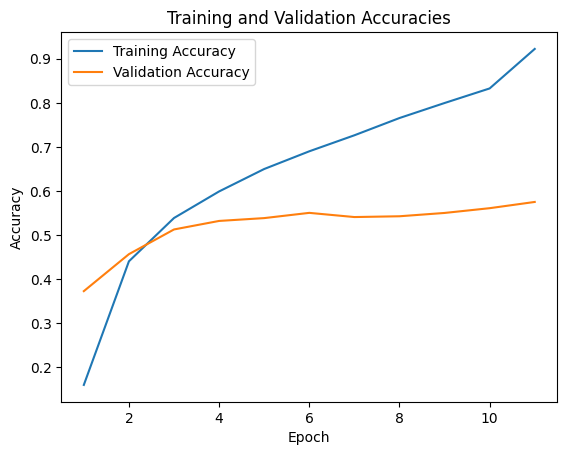

In [38]:
import matplotlib.pyplot as plt

# Plot training and validation losses starting from index 1
epochs = range(1, len(train_losses) + 1)  # Generate the range of epochs starting from 1

# Plot training and validation accuracies
plt.plot(epochs, train_accuracies, label='Training Accuracy')  # Plot training accuracies over epochs
plt.plot(epochs, val_accuracies, label='Validation Accuracy')  # Plot validation accuracies over epochs
plt.xlabel('Epoch')  # Set label for the x-axis
plt.ylabel('Accuracy')  # Set label for the y-axis
plt.title('Training and Validation Accuracies')  # Set title for the plot
plt.legend()  # Display legend
plt.show()  # Show the plot

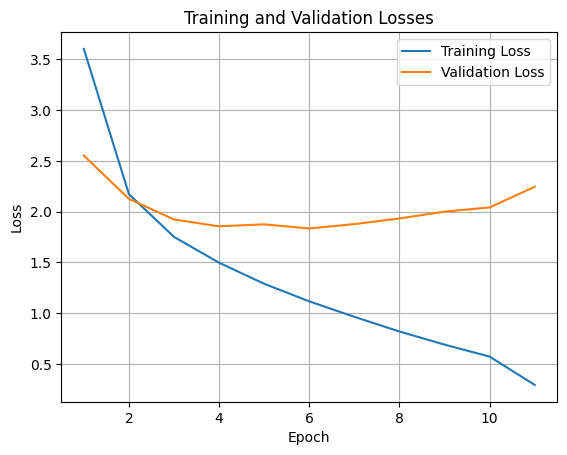

In [39]:
# Plot training and validation losses starting from index 1
epochs = range(1, len(train_losses) + 1)  # Generate the range of epochs starting from 1

# Plot training and validation losses
plt.plot(epochs, train_losses, label='Training Loss')  # Plot training losses over epochs
plt.plot(epochs, val_losses, label='Validation Loss')  # Plot validation losses over epochs
plt.xlabel('Epoch')  # Set label for the x-axis
plt.ylabel('Loss')  # Set label for the y-axis
plt.title('Training and Validation Losses')  # Set title for the plot
plt.legend()  # Display legend
plt.grid(True)  # Display grid
plt.show()  # Show the plot

# GoogLeNet Model 2

In [26]:
googlenet2 = models.googlenet(pretrained=True)
num_features = googlenet2.fc.in_features
num_layers = sum(p.numel() > 0 for name, p in googlenet2.named_parameters())
# Freeze all layers except for the last two layers
for name, param in googlenet2.named_parameters():
    if not name.startswith('aux'):  # Exclude auxiliary classifier parameters if present
        if 'fc' in name or 'classifier' in name:  # Unfreeze the last two layers
            param.requires_grad = True
        else:
            param.requires_grad = False

for name, param in googlenet2.named_parameters():
    print(f'{name}: requires_grad={param.requires_grad}')  

conv1.conv.weight: requires_grad=False
conv1.bn.weight: requires_grad=False
conv1.bn.bias: requires_grad=False
conv2.conv.weight: requires_grad=False
conv2.bn.weight: requires_grad=False
conv2.bn.bias: requires_grad=False
conv3.conv.weight: requires_grad=False
conv3.bn.weight: requires_grad=False
conv3.bn.bias: requires_grad=False
inception3a.branch1.conv.weight: requires_grad=False
inception3a.branch1.bn.weight: requires_grad=False
inception3a.branch1.bn.bias: requires_grad=False
inception3a.branch2.0.conv.weight: requires_grad=False
inception3a.branch2.0.bn.weight: requires_grad=False
inception3a.branch2.0.bn.bias: requires_grad=False
inception3a.branch2.1.conv.weight: requires_grad=False
inception3a.branch2.1.bn.weight: requires_grad=False
inception3a.branch2.1.bn.bias: requires_grad=False
inception3a.branch3.0.conv.weight: requires_grad=False
inception3a.branch3.0.bn.weight: requires_grad=False
inception3a.branch3.0.bn.bias: requires_grad=False
inception3a.branch3.1.conv.weight: re

In [27]:
class CustomModelHead(nn.Module):
  def __init__(self, num_features, dropout_ratio=0.5):
    super(CustomModelHead, self).__init__()
    self.adaptive_pool = nn.AdaptiveAvgPool2d((1, 1))
    self.flatten = nn.Flatten()
    self.fc1 = nn.Linear(num_features, 512)
    self.relu1 = nn.ReLU()
    self.dropout1 = nn.Dropout(p=dropout_ratio)  # Add dropout layer
    self.fc2 = nn.Linear(512, 256)
    self.relu2 = nn.ReLU()
    self.dropout2 = nn.Dropout(p=dropout_ratio)  # Add dropout layer
    self.fc3 = nn.Linear(256, num_classes)
    self.log_softmax = nn.LogSoftmax(dim=1)

  def forward(self, x):
    x = self.adaptive_pool(x.unsqueeze(-1).unsqueeze(-1))
    x = self.flatten(x)
    x = self.fc1(x)
    x = self.relu1(x)
    x = self.dropout1(x)  # Apply dropout after ReLU
    x = self.fc2(x)
    x = self.relu2(x)
    x = self.dropout2(x)  # Apply dropout after ReLU
    x = self.fc3(x)
    x = self.log_softmax(x)
    return x

In [28]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(googlenet2.parameters(), lr=0.0001)

In [29]:
# parameters

#checkpoint_path = '/content/drive/MyDrive/UTS SEM4/94691 Deep Learning/DL_AT2/food-101/checkpoints/googlenet_partb_1'
checkpoint_path = '/content/drive/MyDrive/checkpoints/googlenet_partb_1'

from torch.optim.lr_scheduler import ReduceLROnPlateau  # Import ReduceLROnPlateau scheduler from PyTorch

class CustomCallback:
    def __init__(self, early_stop_patience=5, reduce_lr_factor=0.2, reduce_lr_patience=3, reduce_lr_min_lr=0.0000001, checkpoint_path= checkpoint_path, log_dir='logs'):
        # Initialize callback parameters
        self.early_stop_patience = early_stop_patience  # Patience for early stopping
        self.reduce_lr_factor = reduce_lr_factor  # Factor by which to reduce learning rate
        self.reduce_lr_patience = reduce_lr_patience  # Patience for reducing learning rate
        self.reduce_lr_min_lr = reduce_lr_min_lr  # Minimum learning rate
        #self.checkpoint_path = checkpoint_path  # Path to save model checkpoints
        # self.log_dir = log_dir  # Directory for logging

        # Initialize variables for early stopping
        self.early_stop_counter = 0  # Counter for early stopping
        self.best_val_loss = float('inf')  # Best validation loss

        self.optimizer = None  # Optimizer for training
        self.scheduler = None  # Learning rate scheduler

    def set_optimizer(self, optimizer):
        # Set optimizer for training
        self.optimizer = optimizer

    def on_epoch_end(self, epoch, val_loss):
        # Early Stopping
        if val_loss < self.best_val_loss:
            self.best_val_loss = val_loss
            self.early_stop_counter = 0  # Reset counter if validation loss improves
        else:
            self.early_stop_counter += 1  # Increment counter if validation loss does not improve

        if self.early_stop_counter >= self.early_stop_patience:
            print("Early stopping triggered!")
            return True  # Stop training if early stopping criterion is met

        # Reduce LR on Plateau
        if self.scheduler is not None:
            self.scheduler.step(val_loss)  # Adjust learning rate based on validation loss

        return False  # Continue training

    def on_train_begin(self):
        # Initialize Reduce LR on Plateau scheduler
        self.scheduler = ReduceLROnPlateau(self.optimizer, mode='min', factor=self.reduce_lr_factor,
                                            patience=self.reduce_lr_patience, min_lr=self.reduce_lr_min_lr)

    def on_train_end(self):
       pass
    def set_model(self, model):
        self.model = model  # Set model for the callback

In [30]:
custom_callback = CustomCallback()
custom_callback.set_optimizer(optimizer)
custom_callback.set_model(googlenet2)

In [31]:
lr_scheduler_googlenet2 = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, min_lr=1e-6)

In [40]:
# Initialize lists to store epoch-wise values
train_losses = []  # List to store training losses
train_accuracies = []  # List to store training accuracies
val_losses = []  # List to store validation losses
val_accuracies = []  # List to store validation accuracies

num_epochs = 50
# Training loop
for epoch in range(num_epochs):
    # Training
    # Inside the training loop
    running_train_loss = 0.0  # Initialize running training loss
    correct_train = 0  # Initialize number of correctly predicted training samples
    total_train = 0  # Initialize total number of training samples
    for inputs, labels in train_loader:
        # inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = googlenet2(inputs)
        if isinstance(outputs, tuple):
            logits = outputs[0]
        else:
            logits = outputs

        # Ensure proper gradient tracking
        #logits.requires_grad = True
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(logits, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
    # Calculate epoch-wise training loss and accuracy
    epoch_train_loss = running_train_loss / len(train_loader.dataset)  # Average training loss
    train_accuracy = correct_train / total_train  # Training accuracy

    # Validation
    googlenet2.eval()  # Set the model to evaluation mode
    running_val_loss = 0.0  # Initialize running validation loss
    correct_val = 0  # Initialize number of correctly predicted validation samples
    total_val = 0  # Initialize total number of validation samples
    with torch.no_grad():
        for inputs, labels in valid_loader:
            # inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU if available
            inputs.shape
            outputs = googlenet2(inputs)  # Forward pass
            if isinstance(outputs, tuple):
                logits = outputs[0]  # Unpack logits if model returns tuple
            else:
                logits = outputs
            loss = criterion(logits, labels)  # Calculate loss

            running_val_loss += loss.item() * inputs.size(0)  # Accumulate validation loss
            _, predicted = torch.max(logits, 1)  # Get predicted labels
            total_val += labels.size(0)  # Increment total validation samples
            correct_val += (predicted == labels).sum().item()  # Increment correctly predicted validation samples

    # Calculate epoch-wise validation loss and accuracy
    epoch_val_loss = running_val_loss / len(valid_loader.dataset)  # Average validation loss
    val_accuracy = correct_val / total_val  # Validation accuracy

    # Append values to lists
    train_losses.append(epoch_train_loss)  # Append training loss
    train_accuracies.append(train_accuracy)  # Append training accuracy
    val_losses.append(epoch_val_loss)  # Append validation loss
    val_accuracies.append(val_accuracy)  # Append validation accuracy

    # Step LR scheduler
    lr_scheduler_googlenet2.step(epoch_val_loss)  # Adjust learning rate based on validation loss

    # Check early stopping
    if custom_callback.on_epoch_end(epoch, epoch_val_loss):
        break  # Stop training if early stopping criterion is met

    #Print epoch results
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Loss: {epoch_val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

Epoch [1/50], Train Loss: 4.9469, Train Accuracy: 0.0279, Val Loss: 4.3742, Val Accuracy: 0.0702
Epoch [2/50], Train Loss: 3.9749, Train Accuracy: 0.1287, Val Loss: 3.6971, Val Accuracy: 0.1748
Epoch [3/50], Train Loss: 3.4020, Train Accuracy: 0.2281, Val Loss: 3.2786, Val Accuracy: 0.2514
Epoch [4/50], Train Loss: 3.0425, Train Accuracy: 0.2983, Val Loss: 3.0134, Val Accuracy: 0.3020
Epoch [5/50], Train Loss: 2.7978, Train Accuracy: 0.3467, Val Loss: 2.8410, Val Accuracy: 0.3360
Epoch [6/50], Train Loss: 2.6245, Train Accuracy: 0.3799, Val Loss: 2.7157, Val Accuracy: 0.3630
Epoch [7/50], Train Loss: 2.4944, Train Accuracy: 0.4053, Val Loss: 2.6235, Val Accuracy: 0.3808
Epoch [8/50], Train Loss: 2.3934, Train Accuracy: 0.4281, Val Loss: 2.5502, Val Accuracy: 0.3921
Epoch [9/50], Train Loss: 2.3098, Train Accuracy: 0.4450, Val Loss: 2.4943, Val Accuracy: 0.4032
Epoch [10/50], Train Loss: 2.2500, Train Accuracy: 0.4580, Val Loss: 2.4600, Val Accuracy: 0.4100
Epoch [11/50], Train Loss: 2.

In [38]:
# Evaluation for test data
googlenet2.eval()  # Set model to evaluation mode
test_correct = 0  # Initialize number of correctly predicted samples
test_total = 0  # Initialize total number of samples
test_running_loss = 0.0  # Initialize running test loss

with torch.no_grad():  # Turn off gradients during evaluation
    for inputs, labels in test_loader:  # Iterate through test data
        # inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU
        outputs = googlenet2(inputs)  # Get model predictions
        if isinstance(outputs, tuple):
            logits = outputs[0]  # Unpack logits from model outputs if necessary
        else:
            logits = outputs
        loss = criterion(logits, labels)  # Calculate loss

        test_running_loss += loss.item() * inputs.size(0)  # Update running test loss
        _, predicted = torch.max(logits, 1)  # Get predicted labels
        test_total += labels.size(0)  # Update total number of samples
        test_correct += (predicted == labels).sum().item()  # Update number of correctly predicted samples

# Calculate test loss and accuracy
test_loss = test_running_loss / len(test_loader.dataset)  # Average test loss
test_accuracy = test_correct / test_total  # Test accuracy

# Print test results
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

Test Loss: 2.3400, Test Accuracy: 0.4350


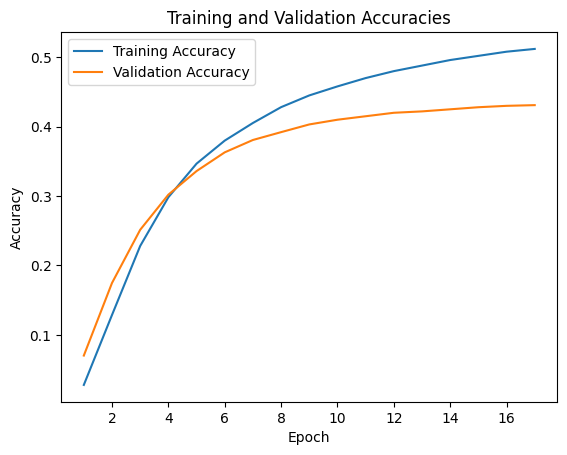

In [34]:
import matplotlib.pyplot as plt

# Plot training and validation losses starting from index 1
epochs = range(1, len(train_losses) + 1)  # Generate the range of epochs starting from 1

# Plot training and validation accuracies
plt.plot(epochs, train_accuracies, label='Training Accuracy')  # Plot training accuracies over epochs
plt.plot(epochs, val_accuracies, label='Validation Accuracy')  # Plot validation accuracies over epochs
plt.xlabel('Epoch')  # Set label for the x-axis
plt.ylabel('Accuracy')  # Set label for the y-axis
plt.title('Training and Validation Accuracies')  # Set title for the plot
plt.legend()  # Display legend
plt.show()  # Show the plot

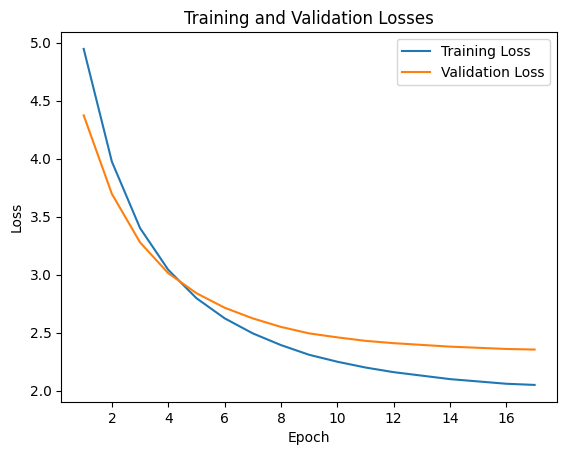

In [35]:
# Plot training and validation losses starting from index 1
epochs = range(1, len(train_losses) + 1)  # Generate the range of epochs starting from 1

# Plot training and validation losses
plt.plot(epochs, train_losses, label='Training Loss')  # Plot training losses over epochs
plt.plot(epochs, val_losses, label='Validation Loss')  # Plot validation losses over epochs
plt.xlabel('Epoch')  # Set label for the x-axis
plt.ylabel('Loss')  # Set label for the y-axis
plt.title('Training and Validation Losses')  # Set title for the plot
plt.legend()  # Display legend
plt.grid(True)  # Display grid
plt.show()  # Show the plot